# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Statistical Methods Topic III. Correlated Errors, $\chi^2$, Maximum Likelihood, and MCMC

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics. It is based on notes from David Weinberg with modifications and additions by Paul Martini.
David's original notes are available from his website: http://www.astronomy.ohio-state.edu/~dhw/A8824/index.html

#### Background reading in Statistics, Data Mining, and Machine Learning in Astronomy: 
- Bivariate and Multivariate Gaussians, see $\S\S 3.5.2-3.5.4$ 
- Parameter Errors in a Maximum Likelihood or Posterior Estimate, see $\S 4.2.5$

In [1]:
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

LaTex macros hidden here -- 
$\newcommand{\expect}[1]{{\left\langle #1 \right\rangle}}$
$\newcommand{\intinf}{\int_{-\infty}^{\infty}}$
$\newcommand{\xbar}{\overline{x}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\like}{{\cal L}}$
$\newcommand{\llike}{{\rm ln}{\cal L}}$
$\newcommand{\xhat}{\hat{x}}$
$\newcommand{\yhat}{\hat{y}}$
$\newcommand{\xhati}{\hat{x}_i}$
$\newcommand{\yhati}{\hat{y}_i}$
$\newcommand{\sigxi}{\sigma_{x,i}}$
$\newcommand{\sigyi}{\sigma_{y,i}}$
$\newcommand{\cij}{C_{ij}}$
$\newcommand{\cinvij}{C^{-1}_{ij}}$
$\newcommand{\cinvkl}{C^{-1}_{kl}}$
$\newcommand{\valpha}{\vec \alpha}$
$\newcommand{\vth}{\vec \theta}$

### Bivariate and Multivariate Gaussians

Suppose we have two independent variables $x$ and $y$ drawn from Gaussian distributions of width $\sigma_x$ and $\sigma_y$. The joint distribution $p(x,y)=p(x)p(y)$ is a bivariate Gaussian, and the values of $x$ and $y$ are uncorrelated:
$$
\langle (x-\mu_x)(y-\mu_y)\rangle = 0.
$$
In this uncorrelated case, the distribution is:
$$
p(x, y) = p(x)p(y) = \frac{1}{2 \pi \sigma_x \sigma_y} \exp \left[ -\frac{1}{2} \left( \frac{(x - \mu_x)^2}{\sigma_x^2}  + \frac{(y - \mu_y)^2}{\sigma_y^2} \right) \right]
$$

If we now consider
$$\eqalign{
x^\prime &= x\cos\alpha-y\sin\alpha \cr
y^\prime &= x\sin\alpha+y\cos\alpha 
}
$$
then we "rotate" the distribution by angle $\alpha$. The distribution $p(x^\prime,y^\prime)$ is still a bivariate
Gaussian, but now the values of $x^\prime$ and $y^\prime$ are correlated.

In this case the bivariate Gaussian expression is: 
$$
p(x, y) = \frac{1}{2\pi \sqrt{\sigma_x^2 \sigma_y^2 - \sigma_{xy}^2} } \exp \left[  \frac{-z^2}{2 (1 - \rho^2) } \right]
$$
where
$$
z^2 = \frac{(x - \mu_x)^2}{\sigma_x^2} + \frac{(y - \mu_y)^2}{\sigma_y^2} - 2 \rho \frac{ (x - \mu_x)(y - \mu_y) }{\sigma_x \sigma_y} 
$$
and the correlation coefficient is
$$
\rho = \frac{\sigma_{xy}}{\sigma_x \sigma_y}
$$
The quantity $\sqrt{\sigma_x^2 \sigma_y^2 - \sigma_{xy}^2} = \sqrt{ \mathrm{det} C}$. In the case of no correlation, $\sigma_{xy} = 0$ and this expression reduces to the previous one. 


If we go to an arbitrary number of random variables $z_i$, $i=1...M$ (e.g. x, y, ...), which we combine into a vector ${\bf z}$, then the covariance matrix is
$$
C_{ij} = \langle (z_i-\langle{z_i\rangle}) (z_j-\langle{z_j}\rangle)\rangle ~.
$$
where $\sigma_{ij}$ is the covariance between $z_i$ and $z_j$ if $i \ne j$. 

If the distribution $p({\bf z})$ is a multivariate Gaussian then
$$
p({\bf z}) =  {1 \over (2\pi)^{M/2} \sqrt{{\rm det}({\bf C})}}
  \exp\left(-{1\over 2} \Delta z_i \cinvij \Delta z_j\right) ~,
$$
where $\Delta z_i = z_i-\langle z_i \rangle$, $\cinvij$ is the inverse covariance matrix, and I have used the Einstein summation convention: repeated indices ($i,j$ in this case) are automatically summed over.

This can also be written in vector/matrix notation.

Text(-4, 4, '$\\sigma_{12} = 0.5$')

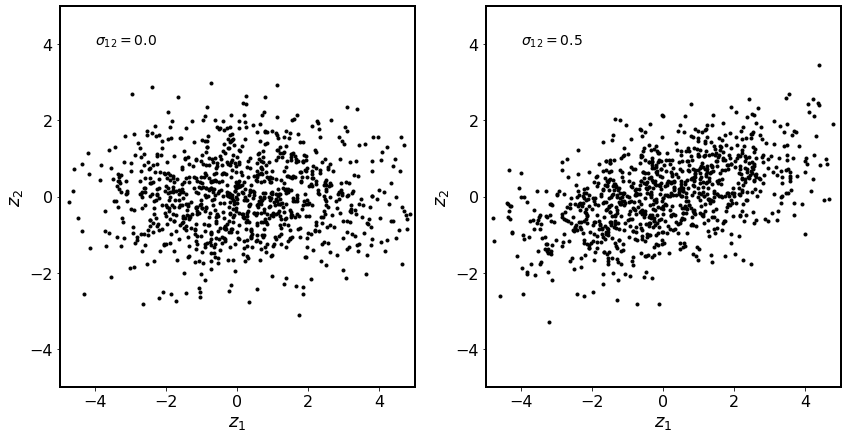

In [2]:
### Modifification of example from "Stats 1" (StatsBackground)

np.random.seed(1216)

sig_z1 = 4
sig_z2 = 1
sig_z12 = 0
mean = np.array([0, 0], dtype=float)
cov = np.array( [[sig_z1, sig_z12], [sig_z12, sig_z2]], dtype=float)
z = np.random.multivariate_normal(mean, cov, size=1000)

fig, axarr = plt.subplots(1, 2, figsize=(14,7))

axarr[0].plot(z.T[0], z.T[1], 'k.')
axarr[0].set_xlabel(r"$z_1$")
axarr[0].set_ylabel(r"$z_2$")
axarr[0].set_xlim(-5, 5)
axarr[0].set_ylim(-5, 5)
axarr[0].text(-4, 4, r"$\sigma_{12} = 0.0$")

sig_z12 = 1.
mean = np.array([0, 0], dtype=float)
cov = np.array( [[sig_z1, sig_z12], [sig_z12, sig_z2]], dtype=float)
z = np.random.multivariate_normal(mean, cov, size=1000)

axarr[1].plot(z.T[0], z.T[1], 'k.')
axarr[1].set_xlabel(r"$z_1$")
axarr[1].set_ylabel(r"$z_2$")
axarr[1].set_xlim(-5, 5)
axarr[1].set_ylim(-5, 5)
axarr[1].text(-4, 4, r"$\sigma_{12} = 0.5$")

### Correlated Errors: Observables and Parameters

Sometimes the errors on data points are correlated.

For example, there may be a calibration uncertainty that affects many data points in the same way.  For galaxy clustering statistics, measurement errors at different scales are usually correlated.

Even if the errors on data points are uncalibrated, the errors on _parameters_ derived from a multi-parameter fit to the data (e.g., the slope and amplitude of a line) are often correlated, unless one has deliberately constructed parameters that have uncorrelated errors.

It is also possible to have correlated errors on data and uncorrelated errors on parameters, though this is less generic than the reverse case.

### Gaussian Likelihoods and $\chi^2$

If we have uncorrelated, Gaussian errors on observables $y$ 
and a model that predicts $y_k=y_{\rm mod}(x_k)$ then the 
likelihood is $L \propto e^{-\chi^2/2}$ where
$$
\chi^2 = \sum_k {(\Delta y_k)^2 \over \sigma_k^2}
$$
with $\Delta y_k = y_k-y_{\rm mod}(x_k)$.

However, if the errors are correlated then we instead have
$$
\chi^2 = \Delta y_k \cinvkl \Delta y_l.
$$

The two definitions coincide for a diagonal covariance matrix
$C_{kl}=\sigma_k^2 \delta_{kl}$, in which case 
$\cinvkl = \delta_{kl}\sigma_k^{-2}$.

### Parameter Errors in a Maximum Likelihood (or Maximum Posterior) Estimate


For a Gaussian probability distribution
$p(x)=(2\pi\sigma^2)^{-1/2}e^{-(x-\mu)^2/2\sigma^2}$,
$$
\ln p = -{1 \over 2} {(x-\mu)^2 \over \sigma^2} + {\rm const}.
$$

Suppose we have estimated a parameter $\theta$ by maximizing either the likelihood $L$ or the posterior probabiliity $L_p$. The first derivative vanishes at the maximum, so a Taylor expansion gives
$$
\ln L \approx \ln L_0 + 
  {1 \over 2}\left({\partial^2 \ln L\over \partial\theta^2}\right)
  (\theta-\theta_0)^2~,
$$
where $\theta_0$ is the location of the maximum.

Identifying the two equations, we infer that if $L(\theta)$ is adequately described by this Taylor expansion, the $1\sigma$ error on $\theta$ is 
$$
\sigma_\theta = 
  \left(-{\partial^2 \ln L\over \partial\theta^2}\right)^{-1/2},
$$
where the derivative is evaluated at the maximum.

For the more general case of a vector of parameters $\theta_i$, we can define the second-derivative matrix
$$
H_{jk} = - {\partial^2\ln L \over \partial\theta_j\partial\theta_k},
$$
which is sometimes called the Hessian matrix or curvature matrix (though terminology and notation are not standard).

One can approximate the log-likelihood as a multi-dimensional paraboloid near its maximum, to find that the likelihood itself is a multi-dimensional Gaussian with covariance matrix
$$
{\rm Cov}(\theta_j,\theta_k) = \sigma_{jk} = H_{jk}^{-1}
$$

Here $(\sigma_{ii})^{1/2}$ is the error on parameter $\theta_i$ marginalized over uncertainties in other parameters.

If $\sigma_{jk} \neq 0$ for some $j \neq k$ then the uncertainties on parameters $\theta_j$ and $\theta_k$ are
correlated.

I have phrased this discussion in terms of likelihood, but it could equally well be phrased in terms of posterior probability: the log of the posterior probability can also be approximated as a paraboloid about its maximum, and one would just substitute $P_{\rm posterior}$ for $L$ in the expressions.

**Notational caution:** Whenever I write $A^{-1}_{jk}$ I mean the $jk$ element of the inverse of matrix $A$, not the reciprocal of the $jk$ element of $A$, which I would write $(A_{jk})^{-1}$.

### Monte Carlo Markov Chains

A fairly common statistical problem is estimating the probability distribution of parameters in a high-dimensional parameter space.

If the 2nd-order expansion described above is adequate, then one "just" needs to find the maximum likelihood solution and compute the second-derivatives of the likelihood with respect to the parameters.

But sometimes this approximation isn't adequate -- a rule-of-thumb that doesn't always work is that the parabolic approximation is good when the fractional errors on _all_ of the parameters are small.


One option is to grid the parameter space finely and compute the posterior probability at all grid locations within it. Marginal distributions can be computed by summing over axes.

This approach is robust and therefore shouldn't be ignored, but it is often computationally impractical.

For example, we might be trying to determine the constraints from a CMB data set $D$ on the set of cosmological parameters $\vth=(\Omega_m,h,\Omega_b,A,n,\tau)$ that determines the CMB spectrum in the simplest current cosmological scenario.

There are tools for calculating $p(D|\vth I)$, but this calculation might take a few seconds, or minutes, for each model in the parameter space.  

Since the parameter space is six-dimensional, even a relatively coarse grid with 10 points along each parameter direction over the plausible range requires $10^6$ evaluations of $p(D|\vth I)$, and if we add another two parameters then $10^6$ becomes $10^8$.

Thus, a naive grid-based evaluation of the likelihood to find best-fit parameters and error bars may be prohibitively expensive.

Monte Carlo Markov Chains (MCMC) are a useful tool for this kind of problem, and this approach has taken rapid hold in the cosmology literature.

In effect, MCMC is doing the necessary integrals for marginalization by Monte Carlo integration.

For details, see the references listed below and the things that they in turn refer to, but in brief the idea is as follows.


The goal is to map the posterior probability distribution $p(\vth | DI) \propto p(\vth | I) p(D|\vth I),$ in the neighborhood of its maximum value.

If the prior $p(\vth|I)$ is flat, then we just have $p(\vth|DI) \propto L$.

Procedure:

1. Start from a randomly chosen point in the parameter space, $\vth = \valpha_1$.

2. Take a random step to a new position $\valpha_2$.

3. If $p(\valpha_2|DI) \geq p(\valpha_1|DI)$, "accept" the step: add $\valpha_2$ to the chain, and substitute $\valpha_2 \rightarrow \valpha_1$. Return to step 2.

4. If $p(\valpha_2|DI) < p(\valpha_1|DI)$, draw a random number $x$ from
a uniform distribution from 0 to 1.  If $x < p(\valpha_2|DI)/p(\valpha_1|DI)$,
"accept"  the step and proceed as in 3.  
If $x\geq p(\valpha_2|DI)/p(\valpha_1|DI)$, reject the step.
Save $\valpha_1$ as another (repeated) link on the chain, and go back to 2.


The chain takes some time to "burn in," i.e., to reach the neighborhood of the most likely solutions.

However, once this happens, a "long enough" chain will have a density of points that is proportional to $p(\vth|DI)$.

To get, for example, the joint pdf of a pair of parameters, one can just make contours of the density of points in the space of those two parameters.  Other "nuisance parameters are marginalized over automatically, because the points sample the full space.

If you want to calculate the posterior distribution of some _function_ of the parameters (e.g., the age of the Universe, given parameter estimates from the CMB), you can just calculate that function for all points in the chain, then plot the pdf of the result.


There are numerous technical issues related to determining whether a chain has "converged" (i.e., is fairly sampling the probability distribution), and to choosing steps in a way that produces fast convergence and good "mixing" (sampling the distribution fairly with a relatively small number of points).  

There is an increasingly extensive literature on MCMC methods. Some starting points are:
Sections 5.8.1 and 5.8.2 of Ivezic et al., and section 15.8 of the 3rd edition of Numerical Recipes, though this topic wasn't in the 1st or 2nd edition.  

An exceedingly useful and enjoyably written reference is Hogg \& Foreman-Mackey (2017, arXiv:1710.06068).
Another that goes a bit further in introducing more advanced methods is Sharma (2017, ARAA, 55, 213).

Properly implemented, MCMC should sample tails or multiple modes of a distribution that are not well described by the Gaussian approximation.

However, if the Gaussian approximation is adequate, then MCMC is not a computationally efficient way to find the parameter PDF.

### MCMC Example

https://emcee.readthedocs.io/en/stable/tutorials/line/

In [3]:
import emcee
from scipy.optimize import minimize

In [4]:
# Start with line example from previous class

def getline(x_i, y_i, sig_x_i, sig_y_i, sig):
    xhat_i = x_i.copy()
    yhat_i = y_i.copy()
    # Apply the scatter to x and y
    for i in range(Npts):
        # apply the error to each point, and add intrinsic scatter to yhat_i
        err_y = np.random.normal(0, sig_y_i[i])
        xhat_i[i] += np.random.normal(0, sig_x_i[i])
        yhat_i[i] += np.random.normal(0, np.sqrt(err_y*err_y + sig*sig) )

    return xhat_i, yhat_i


np.random.seed(1216)
Npts = 100
x_i = np.linspace(0, 10, Npts)
a = 1.
b = 2.
sig_int = 1.0
y_i = a*x_i + b   # True values y_i
sig_x = 0.5
sig_y = sig_x

# Heteroscedastic errors
sig_x_i = np.random.uniform(0.5*sig_x, sig_x, Npts)
sig_y_i = np.random.uniform(0.5*sig_y, sig_y, Npts) 

# Homoscedastic errors
# sig_x_i = 0.5*np.ones(Npts) # np.random.uniform(0.25, 0.5, Npts)
# sig_y_i = 0.5*np.ones(Npts) # np.random.uniform(0.25, 0.5, Npts) 

xhat_i, yhat_i = getline(x_i, y_i, sig_x_i, sig_y_i, sig=sig_int)

def lnlike(theta, xhat_i, yhat_i, sig_x_i, sig_y_i):
    '''
    observations: xhat_i, yhat_i
    uncertainties: sig_x_i, sig_y_i
    model parameters:
       am * x + bm with intrinsic scatter sigma
    '''
    am, bm, sigm = theta
    llike = -0.5*np.log(sigm*sigm + sig_y_i*sig_y_i + am*am*sig_x_i*sig_x_i) - \
        0.5*np.power( yhat_i - am*xhat_i - bm, 2)/(sigm*sigm + sig_y_i*sig_y_i + am*am*sig_x_i*sig_x_i)
    
    return np.sum(llike)

func = lambda *args: -lnlike(*args)
x0 = np.array([a, b, sig_int]) + np.random.randn(3)
print("Starting guess ", x0)
# BFGS is the Broyden, Fletcher, Goldfarb, and Shanno algorithm. It is a second-order method. 
# It approximates the second derivative (Hessian)
result = minimize(func, x0, args=(xhat_i, yhat_i, sig_x_i, sig_y_i), method="BFGS")
errs = np.sqrt(np.diag(result.hess_inv)) # The inverse of the Hessian matrix is the covariance matrix
print("Result for slope, intercept, and intrinsic scatter: ", result.x)
print("Uncertainties on the result: {0:.2f} {1:.2f} {2:.2f}".format(errs[0], errs[1], errs[2]))
print("Input values: ", a, b, sig_int)

Starting guess  [2.07057259 2.47594789 2.68054222]
Result for slope, intercept, and intrinsic scatter:  [0.9770739  2.21260296 1.10361306]
Uncertainties on the result: 0.04 0.24 0.10
Input values:  1.0 2.0 1.0


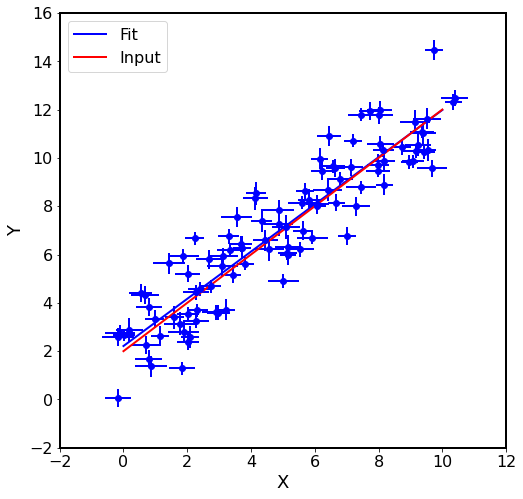

In [5]:
# Plot the result and compare to the input
plt.figure(figsize=(8, 8))
plt.errorbar(xhat_i, yhat_i, xerr=sig_x_i, yerr=sig_y_i, fmt='bo')
ydraw = result.x[0]*x_i + result.x[1]
plt.plot(x_i, ydraw, 'b', label="Fit")
plt.plot(x_i, y_i, 'r', label="Input")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-2, 12)
plt.ylim(-2, 16)
plt.legend()

Now combine the likelihood with a prior to compute the posterior probability

In [6]:
def log_prior(theta):
    am, bm, sigm = theta
    if 0 < am < 5 and -5 < bm < 10 and -10 < np.log(sigm)  < 1: 
        return 0.
    return -np.inf

def lnprob(theta, xhat_i, yhat_i, sig_x_i, sig_y_i):
    '''
    observations: xhat_i, yhat_i
    uncertainties: sig_x_i, sig_y_i
    model parameters:
       am * x + bm with intrinsic scatter sigma
    '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.info
    return lp + lnlike(theta, xhat_i, yhat_i, sig_x_i, sig_y_i)

In [7]:
# Use emcee to sample the posterior pdf

pos = result.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(xhat_i, yhat_i, sig_x_i, sig_y_i)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 761.44it/s]


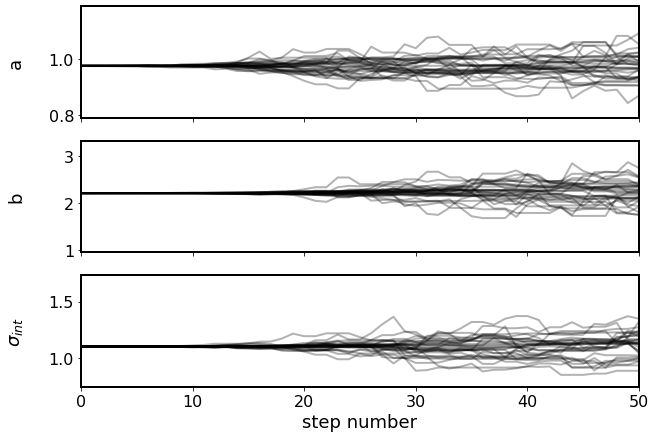

In [8]:
# Initially the walkers are close to the maximum likelihood values, yet after about 
# 40 steps or so they have 'forgotten' that initial value and start to sample the 
# full range

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", r"$\sigma_{int}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 0.01*len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [9]:
# Here is an estimate of the 'autocorrelation time,' which is a measure of 
# how long it takes before the variations have stabilized. This initial time is 
# also called 'burn in.'
tau = sampler.get_autocorr_time()
print(tau)

[37.99045804 37.86944809 41.25302487]


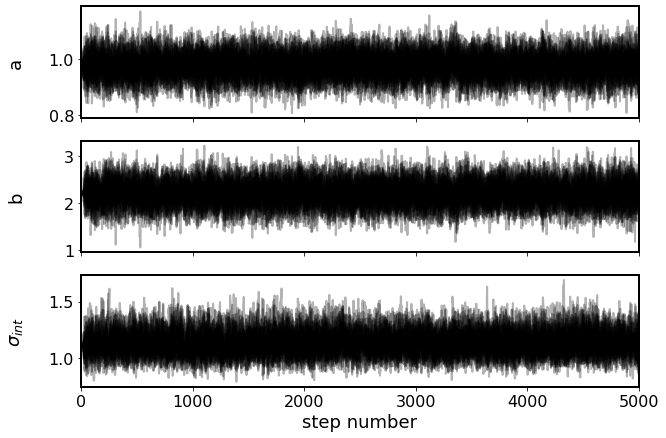

In [10]:
# This shows how they sample the full range

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", r"$\sigma_{int}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
# After burn in, the walkers are sampling the full probability distribution. Here is how to 
# discard the first set of 100 steps:
    
flat_samples = sampler.get_chain(discard=100, thin=5, flat=True)
print(flat_samples.shape)    

(31360, 3)


In [12]:
import corner

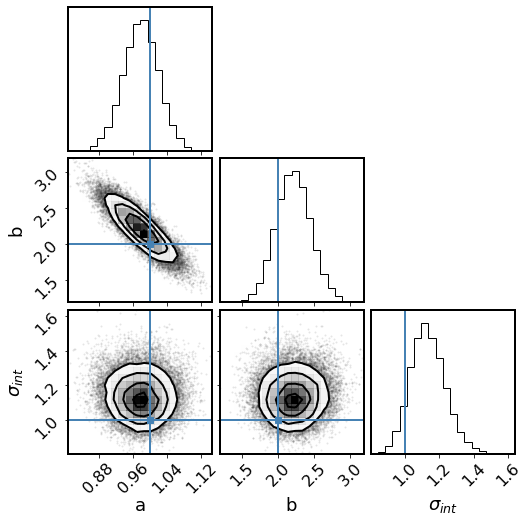

In [13]:
# This shows the distribution of each parameter along with the truth

fig = corner.corner(
    flat_samples, labels=labels, truths=[a, b, sig_int]
);

In [14]:
# For each parameter, calculate the median of the pdf and the width of the marginal distribution:
for i in range(ndim):
    print("{0} = {1:.5f} +/- {2:.5f}".format(labels[i], np.median(flat_samples.T[i]), np.std(flat_samples.T[i])))


a = 0.97842 +/- 0.04216
b = 2.20630 +/- 0.24417
$\sigma_{int}$ = 1.12851 +/- 0.10099


In [15]:
# Compare to scipy.optimize: 
for i in range(ndim):
    print("{0} = {1:.5f} +/- {2:.5f}".format(labels[i], result.x[i], errs[i]))

a = 0.97707 +/- 0.04098
b = 2.21260 +/- 0.23705
$\sigma_{int}$ = 1.10361 +/- 0.09693


(-2.0, 16.0)

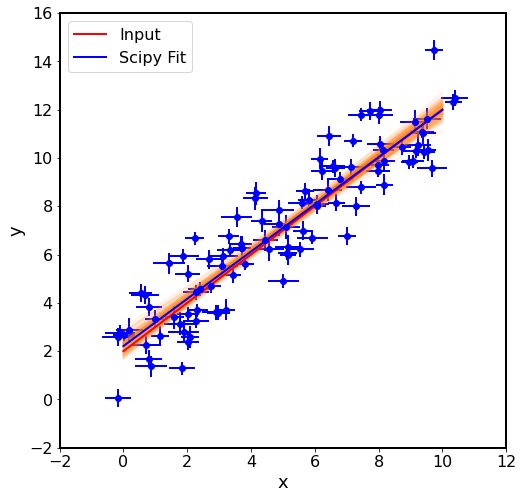

In [16]:
# Plot a random set of 100 samples of a,b to illustrate the uncertainty in the fit

plt.figure(figsize=(8, 8))
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_i, x_i*sample[0] + sample[1], 'C1', alpha=0.1)
plt.errorbar(xhat_i, yhat_i, xerr=sig_x_i, yerr=sig_y_i, fmt='bo')
plt.plot(x_i, y_i, 'r', label="Input")
ydraw = result.x[0]*x_i + result.x[1]
plt.plot(x_i, ydraw, 'b', label="Scipy Fit")
plt.legend(loc='upper left')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-2, 12)
plt.ylim(-2, 16)